In [57]:
# Import Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from FeatureStatCalulateFile import FeatureStat
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [58]:

data = pd.read_csv('data/app_data.csv', index_col=False)
data['X'] = data['X'].astype(float)
data['Y'] = data['Y'].astype(float)
data['Z'] = data['Z'].astype(float)
data['Activity'] = data['Activity'].str.rstrip(';')
data['Activity'] = data['Activity'].str.strip()
# Clean the data
data = data.dropna(subset=['Activity'])  # Drop rows with missing activity
data['Z'] = pd.to_numeric(data['Z'], errors='coerce')  # Convert Z to numeric
data = data.dropna()  # Drop any rows with remaining NaN values

# Ensure 'Activity' is stripped of leading/trailing spaces
data['Activity'] = data['Activity'].str.strip()
corrections = {
    'Walkin': 'Walking',
    'Eating Popconr': 'Eating Popcorn'
}
data['Activity'] = data['Activity'].replace(corrections)

/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_19023/2547746645.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv('data/app_data.csv', index_col=False)


In [59]:
data['Activity'].value_counts()

Activity
Vaping            1459
Eating popcorn    1458
Typing            1216
Drinking Water    1215
Walking           1215
Sitting            244
Name: count, dtype: int64

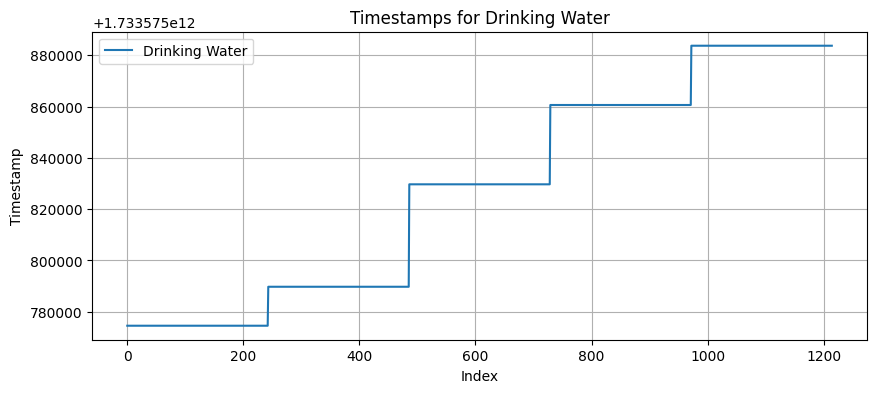

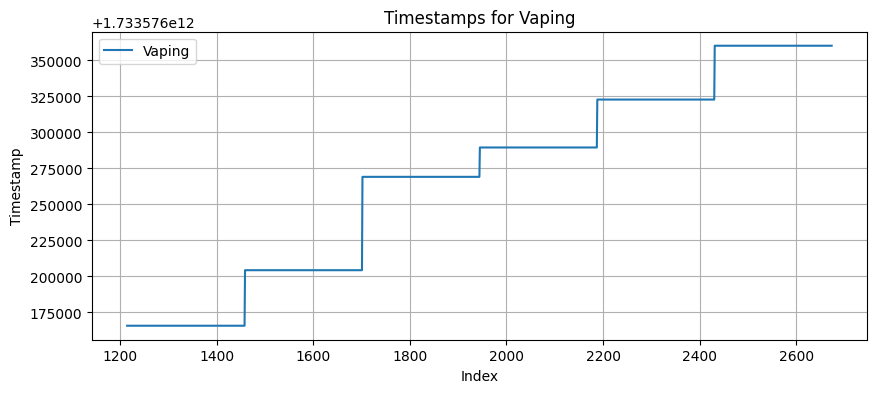

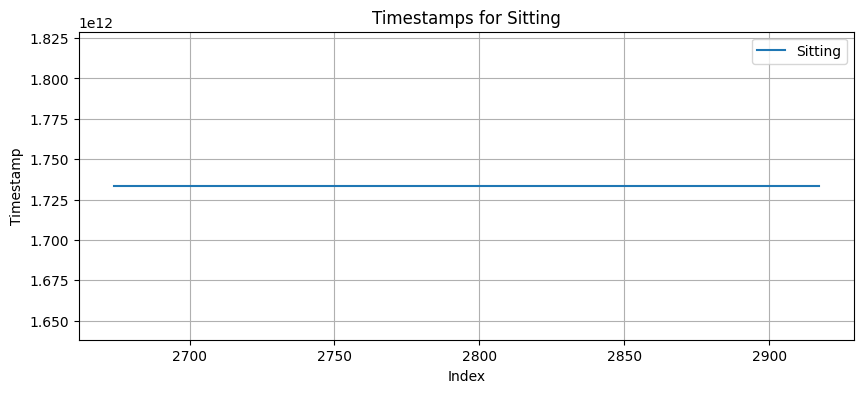

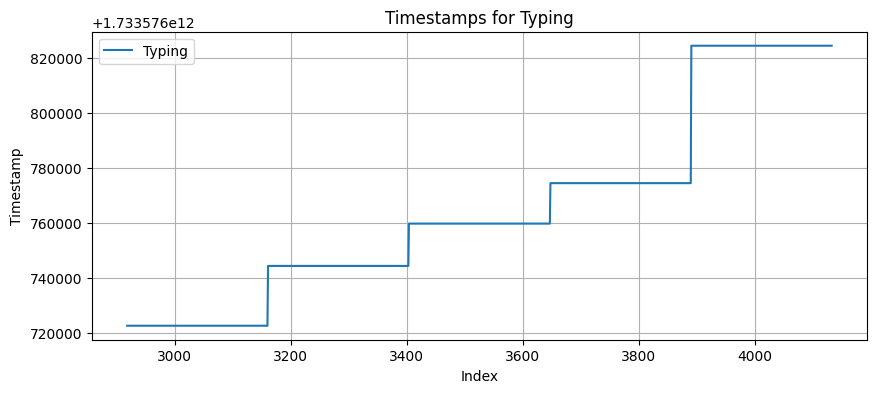

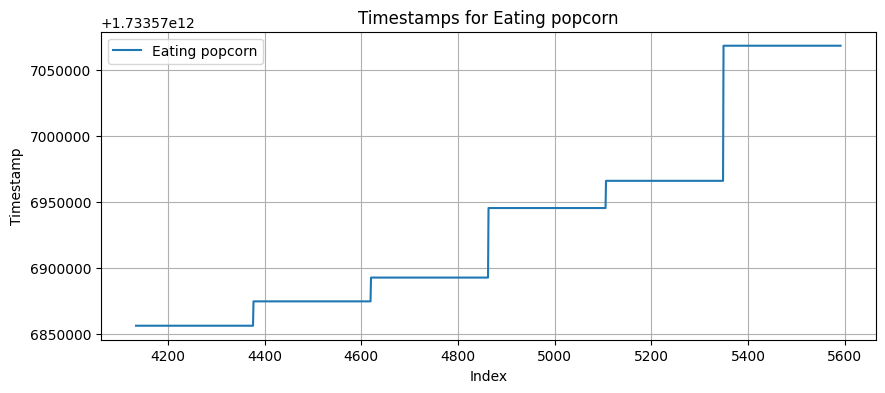

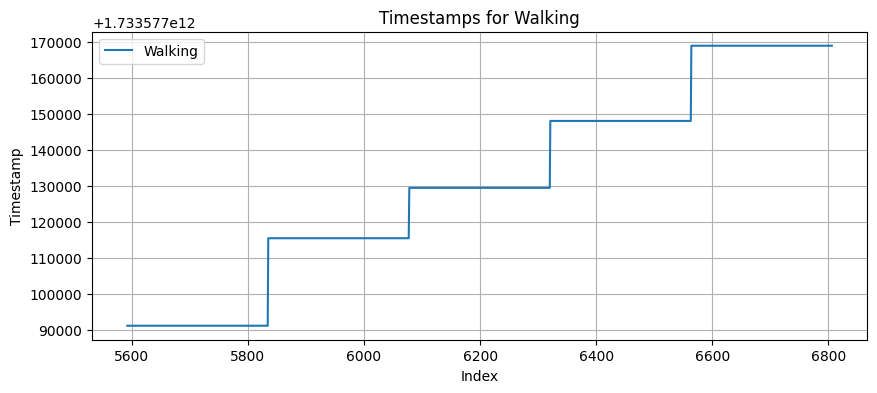

In [52]:
import matplotlib.pyplot as plt

for activity in data['Activity'].unique():
    subset = data[data['Activity'] == activity]
    plt.figure(figsize=(10, 4))
    plt.plot(subset['TimeStamp'], label=activity)
    plt.title(f"Timestamps for {activity}")
    plt.xlabel("Index")
    plt.ylabel("Timestamp")
    plt.legend()
    plt.grid(True)
    plt.show()

In [60]:
# Balance the dataset by selecting a specific number of rows for each activity
drinking_water = data[data['Activity'] == 'Drinking Water'].head(1200)
vaping = data[data['Activity'] == 'Vaping'].head(1200)
typing = data[data['Activity'] == 'Typing'].head(1200)
eating_popcorn = data[data['Activity'] == 'Eating Popconr'].head(1200)
walking = data[data['Activity'] == 'Walking'].head(1200)

balanced_data = pd.DataFrame()
balanced_data = pd.concat([drinking_water, vaping, typing, eating_popcorn, walking])


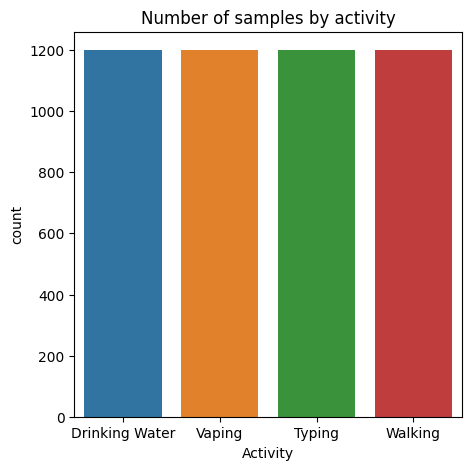

In [61]:
plt.figure(figsize=(5,5))
sns.countplot(x='Activity', data=balanced_data, hue='Activity')
plt.title('Number of samples by activity')
plt.show()

In [62]:
# create window sizes: 

def get_windows(df, window_size, step_size):

    x_list = []
    y_list = []
    z_list = []
    activity_list = []
    for i in range(0, df.shape[0] - window_size, step_size):
        xs = df['X'].values[i : i + window_size]
        ys = df['Y'].values[i : i + window_size]
        zs = df['Z'].values[i : i + window_size]
        label = df['Activity'][i : i + window_size].mode()[0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        activity_list.append(label)
    return x_list, y_list, z_list, activity_list

In [63]:
X = pd.DataFrame()
x_list, y_list, z_list, activity_list = get_windows(balanced_data, 10, 5)
featured_data = FeatureStat(X, x_list, y_list, z_list)
X = featured_data.all()

from sklearn.model_selection import train_test_split

y = pd.Series(activity_list)  # Corresponding labels

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the splits
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Activities ", len(activity_list))


scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)




Train set shape: (766, 59) (766,)
Test set shape: (192, 59) (192,)
Activities  958


In [64]:
decisionTree = DecisionTreeClassifier(random_state=521)
decisionTree.fit(X_train, y_train)
dT_yPred = decisionTree.predict(X_test)
dT_accuracy = accuracy_score(y_test, dT_yPred)
print(f'Accuracy of Decision Tree on App dataset is {dT_accuracy*100:.2f}')
print("\n------------------ Decision Tree Classification Report - app data -------------------\n")
print(classification_report(y_test, dT_yPred))

Accuracy of Decision Tree on App dataset is 79.17

------------------ Decision Tree Classification Report - app data -------------------

                precision    recall  f1-score   support

Drinking Water       0.66      0.56      0.61        48
        Typing       0.80      0.94      0.87        48
        Vaping       0.80      0.77      0.79        48
       Walking       0.88      0.90      0.89        48

      accuracy                           0.79       192
     macro avg       0.79      0.79      0.79       192
  weighted avg       0.79      0.79      0.79       192



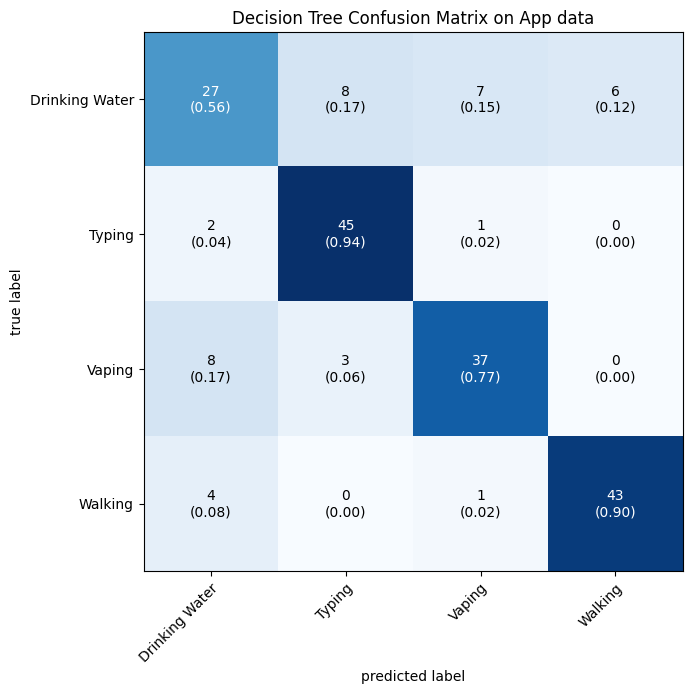

In [65]:
dT_cm = confusion_matrix(y_test, dT_yPred)
plot_confusion_matrix(dT_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Decision Tree Confusion Matrix on App data")
plt.show()

In [66]:
randomForest = RandomForestClassifier(random_state=521)
randomForest.fit(X_train, y_train)
rF_yPred = randomForest.predict(X_test)
rF_accuracy = accuracy_score(y_true=y_test, y_pred=rF_yPred)
print(f'Accuracy of Random Forest on App Data is {rF_accuracy*100:.2f}')
print("\n------------------ Random Forest Classification Report - App Data -------------------\n")
print(classification_report(y_test, rF_yPred))

Accuracy of Random Forest on App Data is 84.90

------------------ Random Forest Classification Report - App Data -------------------

                precision    recall  f1-score   support

Drinking Water       0.76      0.67      0.71        48
        Typing       0.85      0.96      0.90        48
        Vaping       0.85      0.81      0.83        48
       Walking       0.92      0.96      0.94        48

      accuracy                           0.85       192
     macro avg       0.85      0.85      0.85       192
  weighted avg       0.85      0.85      0.85       192



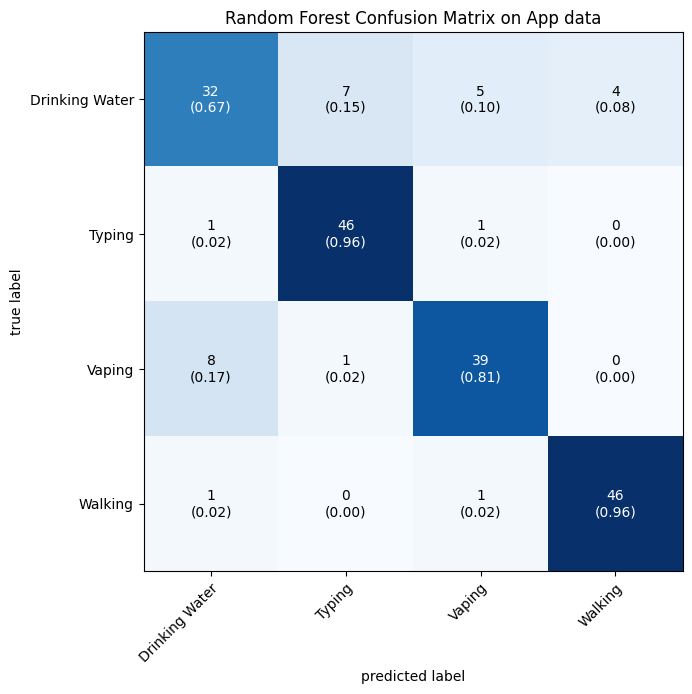

In [67]:
rF_cm = confusion_matrix(y_test, rF_yPred)
plot_confusion_matrix(rF_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Random Forest Confusion Matrix on App data")
plt.show()